In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from astropy.constants import G
from scipy.stats import norm
import os
import emcee
import corner



#G_kpc = G.to('kpc3 / (Msun s2)')
#print(f"G in kpc^3 / (Msun * s^2): {G_kpc.value} {G_kpc.unit}")

In [2]:
G=1

## let's find the mass of the galaxy from the mass of the halo
Moster et all provides an empirical relation: $\dfrac{M_{star}}{M_{halo}} = 2N \left[\left(\dfrac{M_{halo}}{M_1}\right)^{-\beta} + \left(\dfrac{M_{halo}}{M_1}\right)^\gamma\right]^{-1}$, where $N$, $M_1$, $\beta$ and $\gamma$ are just parameters whose estimates can be found in the paper.

In [3]:
def M_1(z):
    M_10 = 11.590
    M_11 = 1.195
    return 10 ** (M_10 + M_11 * z / (z + 1))

def N_(z):
    N_10 = 0.0351
    N_11 = -0.0247
    return N_10 + N_11 * z / (z + 1)

def beta(z):
    beta_10 = 1.376
    beta_11 = -0.826
    return beta_10 + beta_11 * z / (z + 1)

def gamma(z):
    gamma_10 = 0.608
    gamma_11 = 0.329
    return gamma_10 + gamma_11 * z / (z + 1)

def m_star_m_halo(M, z=0):
    a = (M / M_1(z)) ** (-beta(z))
    b = (M / M_1(z)) ** (gamma(z))
    return 2 * M * N_(z) / (a + b)

In [4]:
#stiamo facendo tutto in int units considerando G=1 e massa in masse solari e raggi in kpc
num_particles = 30000

M_H_sun = 10**12# 10**10 msun
M_D_sun = m_star_m_halo(M_H_sun)

print(f'Mass Disk {M_D_sun:.2e}')

Mass Disk 3.43e+10


In [5]:
#proportion to rescale the masses in internal units

M_H_1 = 1000
M_D_1 = M_H_1 * M_D_sun / M_H_sun

print(f'Mass Disk (int units){M_D_1:.5e}')

m_particles = float(M_D_1/num_particles)

Mass Disk (int units)3.42752e+01


M_H = 1000
M_D = M_H / 25

print(M_H/M_D)

In [6]:
M_H = M_H_1
M_D = M_D_1
print ( M_H / M_D)

29.175654835880813


## Myiamoto-Nagai Disk

In [7]:
const = 1.0
a = 3
b = 0.1 * a

R_max = 30 # kpc
z_max = 5

a_H = 10


In [8]:
print(M_D, M_H, a_H, a, b, const)

34.27515185606664 1000 10 3 0.30000000000000004 1.0


In [9]:
def rho_D(R, z):
    ''' Densità volumica di Miyamoto-Nagai  '''
    sqrt_zb = np.sqrt(z**2 + b**2)
    numerator = b**2 * M_D * (a * R**2 + (a + 3 * sqrt_zb) * (a + sqrt_zb)**2)
    denominator = 4 * np.pi * (R**2 + (a + sqrt_zb)**2)**(5/2) * (z**2 + b**2)**(3/2)
    return numerator / denominator


### Posizioni Myiamoto - Nagai Disk

RUN THIS ONLY IF YOU HAVEN'T RUN THE MCMC !!!!!

100%|██████████| 80000/80000 [01:35<00:00, 841.38it/s]


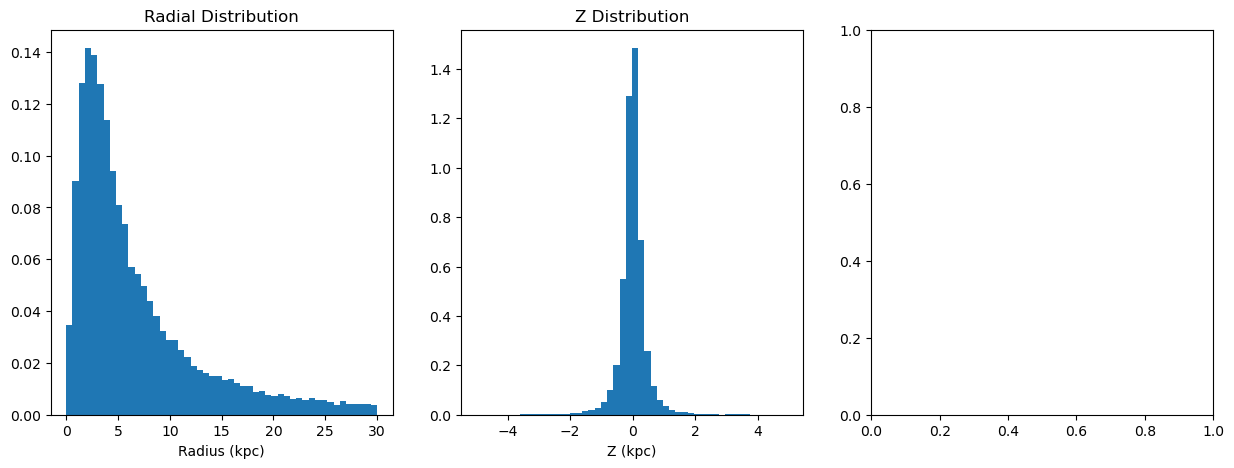

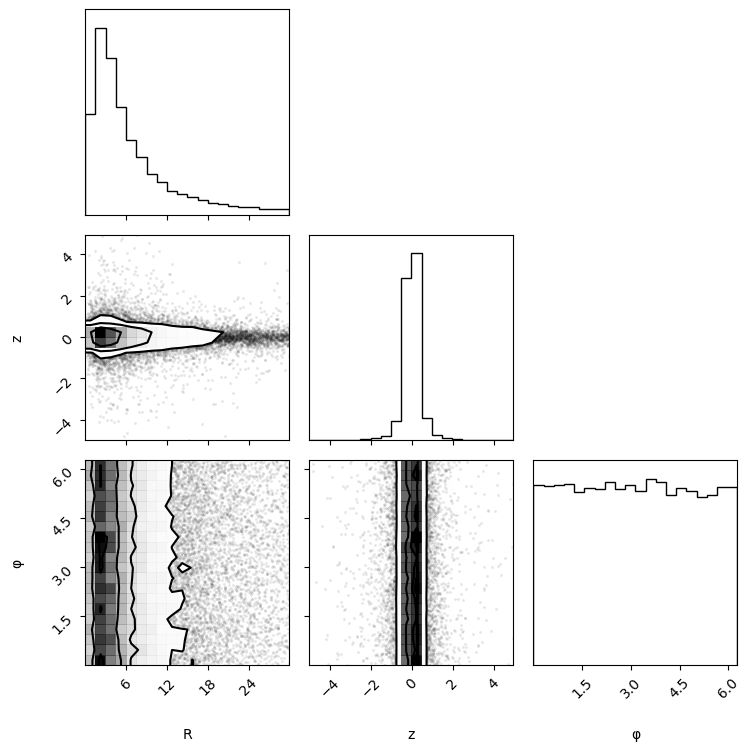

File salvato come coord_equilibrium_2.npy


In [43]:
filename_coord = "coord_equilibrium_2.npy"



if not os.path.exists(filename_coord):
  
    def rho_D(R, z, a=a, b=b):
        ''' Densità volumica di Miyamoto-Nagai  '''
        sqrt_zb = np.sqrt(z**2 + b**2)
        numerator = b**2 * M_D * (a * R**2 + (a + 3 * sqrt_zb) * (a + sqrt_zb)**2)
        denominator = 4 * np.pi * (R**2 + (a + sqrt_zb)**2)**(5/2) * (z**2 + b**2)**(3/2)
        return numerator / denominator


    def log_prior(params):
        # Uniform priors within the specified ranges
        R, z, phi = params
        if (0 <= R <= R_max) and (-z_max <= z <= z_max) and (0 <= phi <= 2*np.pi):
            return 0.0  # uniform prior
        return -np.inf  # log probability of zero if outside ranges

    def log_likelihood(params):
        # Use the density as the likelihood
        R, z, phi = params
        return np.log(rho_D(R, z)*2*np.pi*R)

    def log_posterior(params):
        # Combine prior and likelihood
        lp = log_prior(params)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(params)

    # MCMC Setup
    ndim = 3  # R, z, phi
    nwalkers = 30  # Number of MCMC walkers
    nsteps = 80000  # Number of steps

    # Initial guess - randomly distributed within priors
    initial_guess = np.random.uniform(
        low=[0, -z_max, 0],
        high=[R_max, z_max, 2*np.pi],
        size=(nwalkers, ndim)
    )

    # Run MCMC
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
    sampler.run_mcmc(initial_guess, nsteps, progress=True)


    # Discard burn-in and flatten chains
    tau = sampler.get_autocorr_time()

    
    flat_samples = sampler.get_chain(discard=3000, flat=True, thin = int(np.max(tau)))


    unique_samples = np.unique(flat_samples, axis=0)
    if unique_samples.shape[0] < 30000:
        raise ValueError("Non ci sono abbastanza campioni unici per selezionarne 30,000.")

    flat_samples_subset = unique_samples[np.random.choice(unique_samples.shape[0], 30000, replace=False)]

    # Supponendo che flat_samples sia un array NumPy
    #flat_samples_subset = flat_samples[np.random.choice(flat_samples.shape[0], 30000, replace=False)]

    # Convert to Cartesian coordinates
    R_samples = flat_samples_subset[:, 0]
    z_samples = flat_samples_subset[:, 1]
    phi_samples = flat_samples_subset[:, 2]

    x_particles = R_samples * np.cos(phi_samples)
    y_particles = R_samples * np.sin(phi_samples)
    z_particles = z_samples

    # Visualize results
    plt.figure(figsize=(15,5))

    # Radial distribution
    plt.subplot(131)
    R = np.sqrt(x_particles**2 + y_particles**2)
    plt.hist(R, bins=50, density=True)
    plt.title('Radial Distribution')
    plt.xlabel('Radius (kpc)')

    # Z distribution
    plt.subplot(132)
    plt.hist(z_particles, bins=50, density=True)
    plt.title('Z Distribution')
    plt.xlabel('Z (kpc)')

    # Corner plot to show parameter correlations
    plt.subplot(133)
    corner.corner(flat_samples, labels=['R', 'z', 'φ'])

    plt.tight_layout()
    plt.show()

    coordinates = np.array([x_particles, y_particles, z_particles, R_samples, phi_samples])
    np.save(filename_coord, coordinates)
    print("File salvato come", filename_coord)
else:
    print("Il file", filename_coord, "esiste già.")


In [44]:
# Lettura del file .npy
loaded_coordinates = np.load(filename_coord)
x_particles, y_particles, z_particles, R_particles, phi_particles = loaded_coordinates

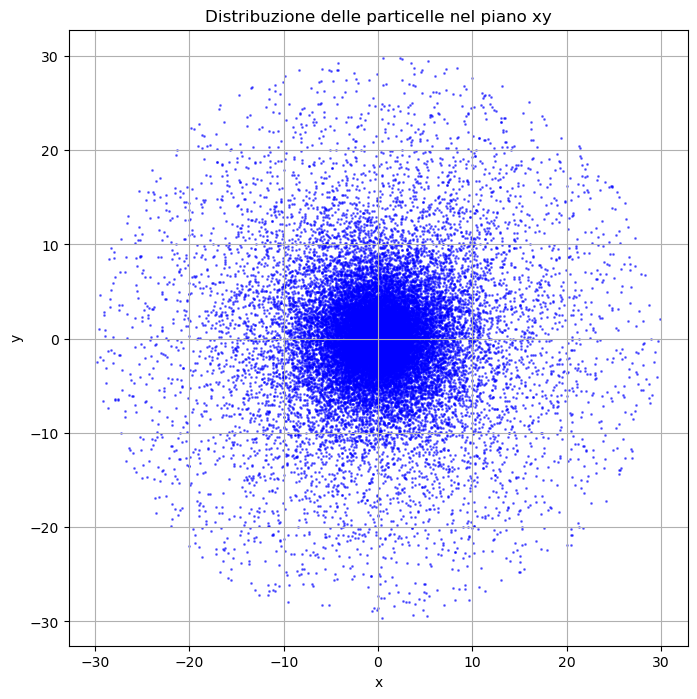

In [45]:
# Plot delle posizioni delle particelle nel piano xy
plt.figure(figsize=(8, 8))
plt.scatter(x_particles, y_particles, s=1, color='blue', alpha=0.5)
plt.title("Distribuzione delle particelle nel piano xy")
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect('equal', adjustable='box')  # Mantieni le proporzioni uguali per x e y
plt.grid(True)
plt.show()


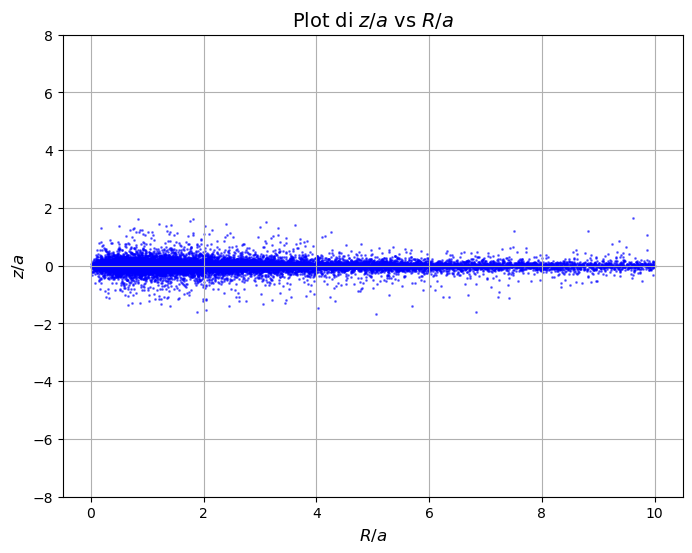

In [46]:
# Plot di z/a vs R/a
plt.figure(figsize=(8, 6))
plt.scatter(np.array(R_particles) / a, np.array(z_particles) / a, s=1, color='blue', alpha=0.5)
plt.xlabel('$R/a$', fontsize=12)
plt.ylabel('$z/a$', fontsize=12)
plt.title('Plot di $z/a$ vs $R/a$', fontsize=14)
plt.grid(True)
plt.ylim(-8,8)
plt.show()

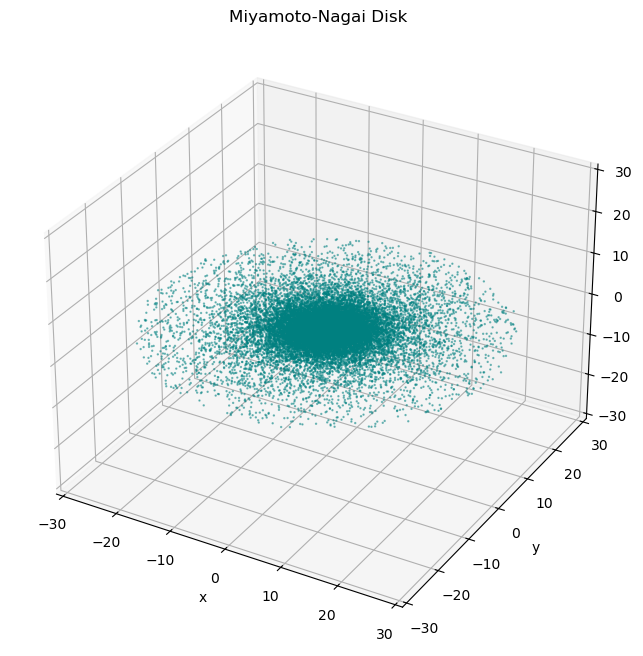

In [47]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Plot delle posizioni delle particelle in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot delle particelle
ax.scatter(x_particles, y_particles, z_particles, s=0.5, color='teal', alpha=0.5)

# Titoli e etichette
ax.set_title("Miyamoto-Nagai Disk")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_xlim(-30,30)
ax.set_ylim(-30,30)
ax.set_zlim(-30,30)

plt.show()


In [48]:
#positions of the particles of the halo
N = num_particles

r_halo = a_H * (1 / (1 - np.sqrt(np.random.random(N))) - 1)
theta_halo = np.arccos(1 - 2 * np.random.random(N))
phi_halo = np.random.uniform(0, 2 * np.pi, N)

x_halo = r_halo * np.sin(theta_halo) * np.cos(phi_halo)
y_halo = r_halo * np.sin(theta_halo) * np.sin(phi_halo)
z_halo = r_halo * np.cos(theta_halo)


In [49]:
N

30000

In [50]:
a_H

10

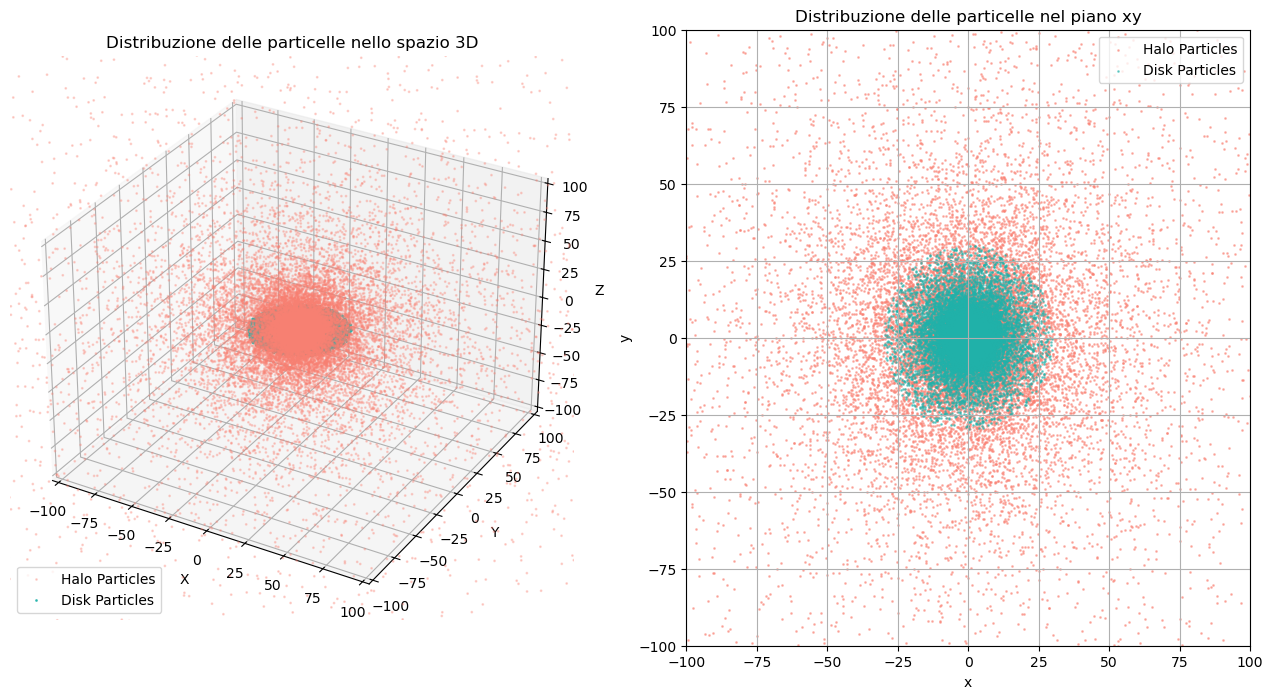

In [51]:
# Create a figure with two subplots
fig = plt.figure(figsize=(16, 8))

# First subplot: 3D plot on the left
ax1 = fig.add_subplot(121, projection='3d')

ax1.scatter(x_halo, y_halo, z_halo, s=1, color='salmon', label='Halo Particles', alpha = 0.3)
ax1.scatter(x_particles, y_particles, z_particles, s=1, color='lightseagreen', alpha=0.8, label='Disk Particles')

ax1.set_title("Distribuzione delle particelle nello spazio 3D")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("Z")
ax1.set_zlim(-100, 100)
ax1.set_xlim(-100, 100)
ax1.set_ylim(-100, 100)

ax1.legend()

# Second subplot: 2D plot on the right
ax2 = fig.add_subplot(122)

ax2.scatter(x_halo, y_halo, s=1, color='salmon', label='Halo Particles', alpha = 0.5)
ax2.scatter(x_particles, y_particles, s=1, color='lightseagreen', alpha=0.5, label='Disk Particles')

ax2.set_title("Distribuzione delle particelle nel piano xy")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
#ax2.set_aspect('equal', adjustable='box')  # Mantieni le proporzioni uguali per x e y
ax2.legend()
ax2.grid(True)
ax2.set_ylim(-100, 100)
ax2.set_xlim(-100, 100)

# Show the combined plot
plt.show()


### Velocities

### Potenziale dell'alone:
$$
\Phi_{\text{halo}}(R, z) = - \frac{G M_H}{\sqrt{R^2 + z^2} + a_H}
$$

### Potenziale del disco:
$$
\Phi_{\text{disk}}(R, z) = - \frac{G M_D}{\sqrt{\left(a_D + \sqrt{z^2 + b^2}\right)^2 + R^2}}
$$

### Derivata del potenziale rispetto a \(R\) per la velocità circolare (z=0):
$$
\frac{\partial \Phi}{\partial R} =\frac{\partial (\Phi_{\text{disk}}+\Phi_{\text{halo}})}{\partial R} = G R \left( M_D \left[\left(a_D + b\right)^2 + R^2\right]^{-\frac{3}{2}} + M_H \frac{1}{\left(R + A\right)^2 R} \right)
$$

### Velocità circolare:
$$
v_{\text{circ}}(R) = \sqrt{R \cdot \frac{\partial \Phi}{\partial R}}
$$

### Distribuzione di v_z

$$
f(v_z) = \frac{1}{\sqrt{2\pi} \sigma_z} \exp\left(-\frac{v_z^2}{2\sigma_z^2}\right)
$$

### Rho Halo, Hernquist
$$
\rho(R, z) = \frac{M}{2\pi} \frac{a}{\sqrt{R^2 + z^2} \left(\sqrt{R^2 + z^2} + a\right)^3}
$$



### Densità di Miyamoto-Nagai
$$
\rho(R, z) = \frac{b^2 M}{4 \pi} \frac{a R^2 + (a + 3\sqrt{z^2 + b^2})(a + \sqrt{z^2 + b^2})^2}{\left[R^2 + (a + \sqrt{z^2 + b^2})^2\right]^{5/2}(z^2 + b^2)^{3/2}}
$$

In Binney's book "In fact, in the epicycle approximation of §3.2.3 the mean radius is equal to the guiding-center radius"



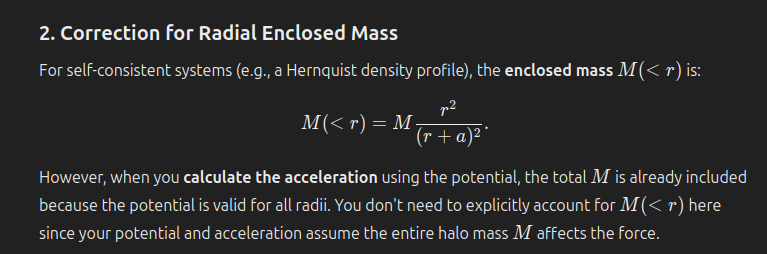

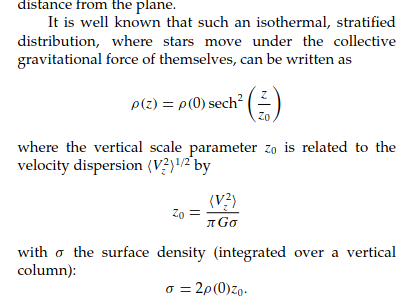

In [52]:
def pot_halo (R,z):
    r = np.sqrt(R**2 + z**2)
    return - G * M_H / (r + a_H) 

def pot_disk (R,z):
    return - G * M_D / np.sqrt((a+np.sqrt(z**2. + b**2.))**2. + R**2.)

def dphi_dr(R): # IN Z = 0 !!!!!!!
    halo_term = G * M_H / (R + a_H)**2
    disk_term = G * M_D * R * ((a + b)**2 + R**2)**(-3./2.)
    return halo_term + disk_term


def second_dphi_dr(R):
    ''' Derivata seconda del potenziale totale (halo + disk) a z=0'''
    halo_term = -2 * G * M_H /((R + a_H)**3)
    disk_term = G * M_D * ((a + b)**2 - 2* R**2) * ((a + b)**2 + R**2)**(-5./2.)
    return halo_term + disk_term
    
def v_circ(R):
    return np.sqrt(dphi_dr(R) * R)

def omega(R):
    return np.sqrt(dphi_dr(R)/R)

def kappa(R):
    return np.sqrt(second_dphi_dr(R) + 3 * dphi_dr(R)/R)

def rho_H(R, z):
    ''' Densità volumica di hernquist  '''
    return (M_H / (2 * np.pi)) * (a / (np.sqrt(R**2 + z**2) * (np.sqrt(R**2 + z**2) + a)**3))

def rho_tot(R,z):
    return rho_D(R,z) + rho_H(R,z)

def sigma_r(R, Q=1.1):
    S = Sigma(R)
    k = kappa(R)
    return 3.36 * Q * G * S / k


def Sigma(R_values):
    ''' Calcola la densità superficiale per ogni R dato'''
    # Preallocazione dell'array per i risultati
    Sigma_values = np.zeros_like(R_values)
    
    # Calcola l'integrale per ciascun valore di R
    for i, R in enumerate(R_values):
        Sigma_values[i] = 2 * np.trapz([rho_D(R, z) for z in np.linspace(0, z_max, 100)], dx=float(z_max/100))
    
    return Sigma_values


def sigma_z(b, R_values):
    surface_density = Sigma(R_values)
    return np.sqrt(np.pi * G * surface_density * b / 2)



def pot_tot(R, z):
    return pot_halo(R, z) + pot_disk(R, z)

def escape_vel (R, z):
    return np.sqrt(-2. * pot_tot(R, z))


'''

def second_dphi_dr (R):
    # derivata seconda del potenziale totale (halo + disk) a z=0
    return dphi_dr(R)/R + G * R * (M_D*(-3*R*((a+b)**2 + R**3)**(-5/2)) - M_H *....



'''

'\n\ndef second_dphi_dr (R):\n    # derivata seconda del potenziale totale (halo + disk) a z=0\n    return dphi_dr(R)/R + G * R * (M_D*(-3*R*((a+b)**2 + R**3)**(-5/2)) - M_H *....\n\n\n\n'

## POSITIONS AND SURFACE DENSITY

In [53]:
x_grid_pot = np.linspace(-10 * a, 10 * a, 100)
y_grid_pot= np.linspace(-10 * a, 10 * a, 100)

X, Y = np.meshgrid(x_grid_pot, y_grid_pot)
Z = -10+ 5* pot_disk(np.sqrt(X**2+Y**2), np.zeros_like(X))


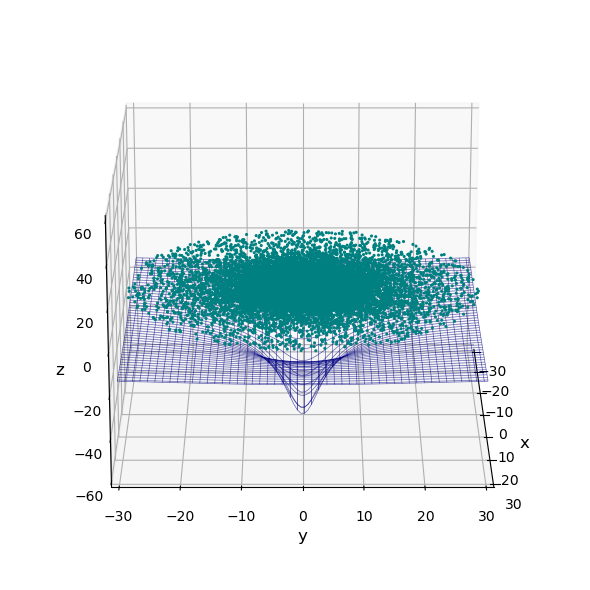

In [54]:

fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(111, projection='3d')

#ax.plot_surface(X, Y, Z, cmap='Spectral', edgecolor='black', lw=0.25, zorder = 0)
ax.plot_wireframe(X, Y, Z, color='navy', lw=0.5, alpha = 0.6)
ax.scatter(x_particles, y_particles, z_particles, alpha=1, s=1.5, c = 'teal')


ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_zlabel('z', fontsize=12)
ax.set_xlim(-10 * a, 10 * a)
ax.set_ylim(-10 * a, 10 * a)
ax.set_zlim(-20 * a, 20 * a)
ax.view_init(elev=20, azim=0)



plt.tight_layout();

#plt.savefig('expdisk-dist.pdf');

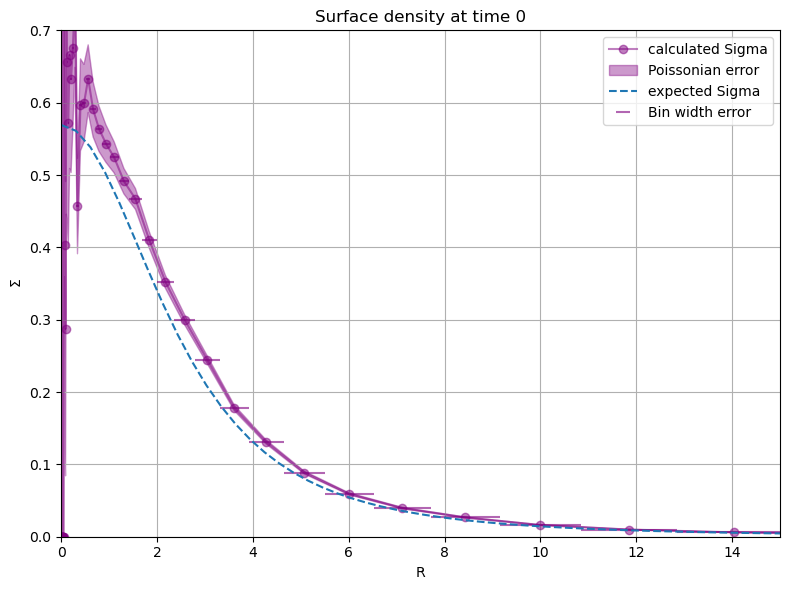

In [63]:
def surface_density_R(masses, positions, num_bins):
    x, y = positions[:, 0], positions[:, 1]
    R = np.sqrt(x**2 + y**2)
    bins = np.geomspace(R.min(), R.max(), num_bins)
    mass_in_bins, bin_edges = np.histogram(R, bins=bins, weights=masses)

    bin_areas = np.zeros(num_bins-1)
    bin_centers = np.zeros(num_bins-1)

    for i in range(len(bin_areas)):
        bin_areas[i] = np.pi * (bin_edges[i+1]**2 - bin_edges[i]**2)
        bin_centers[i] = 0.5 * (bin_edges[i+1] + bin_edges[i])

    surface_density = mass_in_bins / bin_areas
    poisson_errors = np.sqrt(mass_in_bins/masses[0])*masses[0]/ bin_areas  
    bin_errors = (bin_edges[1:] - bin_edges[:-1])/2
    


    return bin_centers, surface_density, poisson_errors, bin_errors
 
R_grid = np.linspace(0, 30, 100)
position = np.array([x_particles, y_particles, z_particles]).T
masses = np.ones(num_particles) * m_particles

fig, ax = plt.subplots(figsize=(8, 6))
# Assuming bin_errors contains the half-widths of the bins
# Retrieve the data
bin_centers_R, surface_density_R_exp, poissonian_error, bin_errors = surface_density_R(masses, position, 50)

# Plot the calculated surface density
ax.plot(bin_centers_R, surface_density_R_exp, marker='o', color='purple', alpha=0.5, label='calculated Sigma')

# Fill between the error bounds on the y-axis
ax.fill_between(bin_centers_R, 
                surface_density_R_exp - poissonian_error, 
                surface_density_R_exp + poissonian_error, 
                color='purple', alpha=0.4, label='Poissonian error')

# Add horizontal error bars (bin width on x-axis)
ax.errorbar(bin_centers_R, surface_density_R_exp, xerr=bin_errors, fmt='none', ecolor='purple', alpha=0.6, label='Bin width error')

# Set plot limits, labels, and legend
ax.set_xlim(0, 15)
ax.set_ylim(0, 0.7)
ax.set_title("Surface density at time 0")
ax.set_xlabel("R")
ax.set_ylabel(r"$\Sigma$")
ax.grid(True)

# Plot the expected surface density
ax.plot(R_grid, Sigma(R_grid), '--', label='expected Sigma')

# Show the legend and plot
plt.legend()
plt.tight_layout()
plt.show()


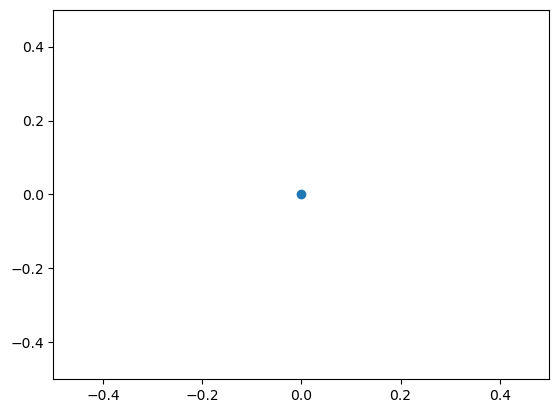

In [69]:
def calcola_centro_di_massa_e_plot(m, x):
    m = m[:, np.newaxis]
    centri_di_massa = np.sum(m * x, axis=1) / np.sum(m)
    #fig = plt.figure()
    #ax = fig.add_subplot(111, projection='3d')
    plt.plot(centri_di_massa[0], centri_di_massa[1], marker='o', linestyle='-')
    #ax.set_xlabel("X")
    #ax.set_ylabel("Y")
    #ax.set_zlabel("Z")
    plt.xlim(-0.5,0.5)
    plt.ylim(-0.5,0.5)
    plt.show()
    return centri_di_massa

centro_di_massa = calcola_centro_di_massa_e_plot(masses, position)


## VELOCITIES

In [70]:
sigma_r_plot= sigma_r(R_particles)
sig_z_plot= sigma_z(b, np.array(R_particles))


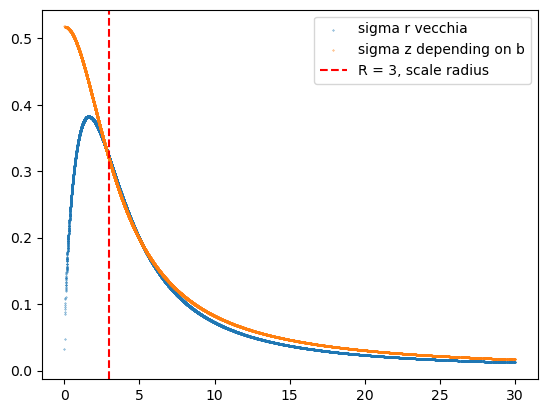

In [71]:
plt.scatter(R_particles, sigma_r_plot, label='sigma r vecchia ', s = 0.1)
plt.scatter(R_particles, sig_z_plot, label = 'sigma z depending on b', s = 0.1)
plt.axvline(3, color = 'red',linestyle = '--', label = 'R = 3, scale radius')
plt.legend()

r_grid = np.linspace(0.1, 30, 100)
plt.plot(r_grid, dphi_dr_halo(r_grid))




In [72]:
#calcoliamo il guiding radius R sul piano xy, considerando la media degli R di halo e disk+
#R_halo = r_halo * np.sin(theta_halo)
R_guid = np.mean(np.concatenate([R_particles])) #abbiamo tolto l'halo nel calcolo di r guid giuusto?
 
print(f'The guiding radius is:{R_guid}')

The guiding radius is:6.702936045066869


In [73]:
sig_r = sigma_z(b, np.array(R_particles))
sig_z = sig_r 
sig_phi = sig_r


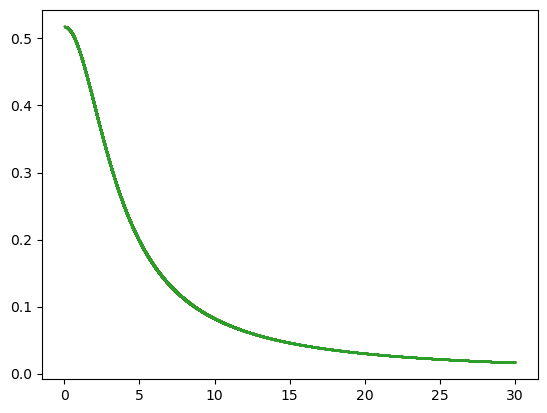

In [74]:
plt.scatter(R_particles, sig_r, label = 'sigma r', s = 0.1)
plt.scatter(R_particles, sig_z, label = 'sigma z', s = 0.1)
plt.scatter(R_particles, sig_phi, label = 'sigma phi', s = 0.1)

In [75]:
v_r = sig_r * np.random.normal(size=num_particles)
v_phi =  v_circ(np.array(R_particles)) + sig_phi * np.random.normal(size=num_particles)

v_x = -v_phi * np.sin(phi_particles) + v_r * np.cos(phi_particles)
v_y = v_phi * np.cos(phi_particles) + v_r * np.sin(phi_particles) 
v_z = sig_z * np.random.normal(size=num_particles)


print(v_circ(np.array(R_particles)))

[5.11980166 3.36214557 5.27264888 ... 4.57773365 4.61900927 5.27362919]


## sigma / velocity

Value of rapporto at R = 3: [0.06842587 0.06859528 0.06849049 0.06860658 0.06864381 0.06873927
 0.06847764 0.0687937  0.06842745 0.06864108 0.06862161 0.06866967
 0.06861655 0.06849825 0.06878811 0.06839317 0.0687584  0.06841653
 0.06871701 0.06873303 0.0685939  0.06839617 0.06870584 0.06838307
 0.06861611 0.06853162 0.06881119 0.06881685 0.06877335 0.06864899
 0.06858736 0.06859946 0.06880171 0.06883863 0.06873805 0.06868766
 0.06845838 0.06878825 0.0686339  0.06850547 0.06856967 0.06867827
 0.06841148 0.06883382 0.06879655 0.06843067 0.06872035 0.06860469
 0.06839729 0.06874725 0.06870969 0.06852803 0.06861324 0.06860941
 0.06841566 0.06839586 0.06860538 0.06847389 0.06877947 0.06852834
 0.0684339  0.06840132 0.06875484 0.06843317 0.0685621  0.06857886
 0.06877343 0.06859384 0.06860627 0.06875873]


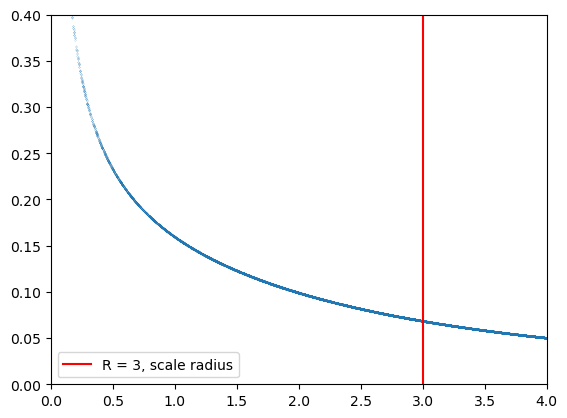

In [76]:
rapporto = sig_phi / v_circ(np.array(R_particles))
plt.plot(R_particles, rapporto, 'o', markersize = 0.1)
plt.xlim(0,4)
plt.ylim(0,0.4)
plt.axvline(3, color = 'red', label = 'R = 3, scale radius')
plt.legend()

rapporto_at_3 = rapporto[np.isclose(R_particles, 3, atol=0.01)]
print(f'Value of rapporto at R = 3: {rapporto_at_3}')

## TOOMRE STABILITY PARAMETER

Number of particles with Q < 1: 0
Q minumum 1.0773941863232748


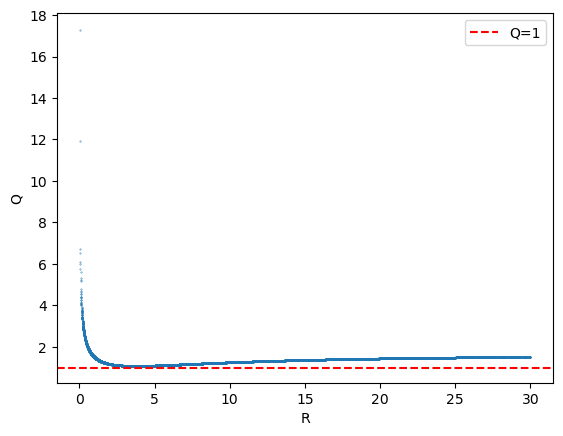

In [77]:
# let's calculate the Q at every radius to check whether it's stable enough
def Q(R, b):
    S = Sigma(R)
    k = kappa(R)
    sigma = sigma_z(b, R)
    return  sigma* k / (3.36 *G * S)

b = b #a* 0.03
Q_particles = Q(R_particles, b)

plt.scatter(R_particles, Q_particles, s = 0.1)
plt.axhline(1, color = 'red', linestyle = '--', label = 'Q=1')
plt.xlabel('R') 
plt.ylabel('Q')
plt.legend()

num_particles_under_1 = np.sum(Q_particles < 1)
print(f'Number of particles with Q < 1: {num_particles_under_1}')

print("Q minumum", np.min(Q_particles))


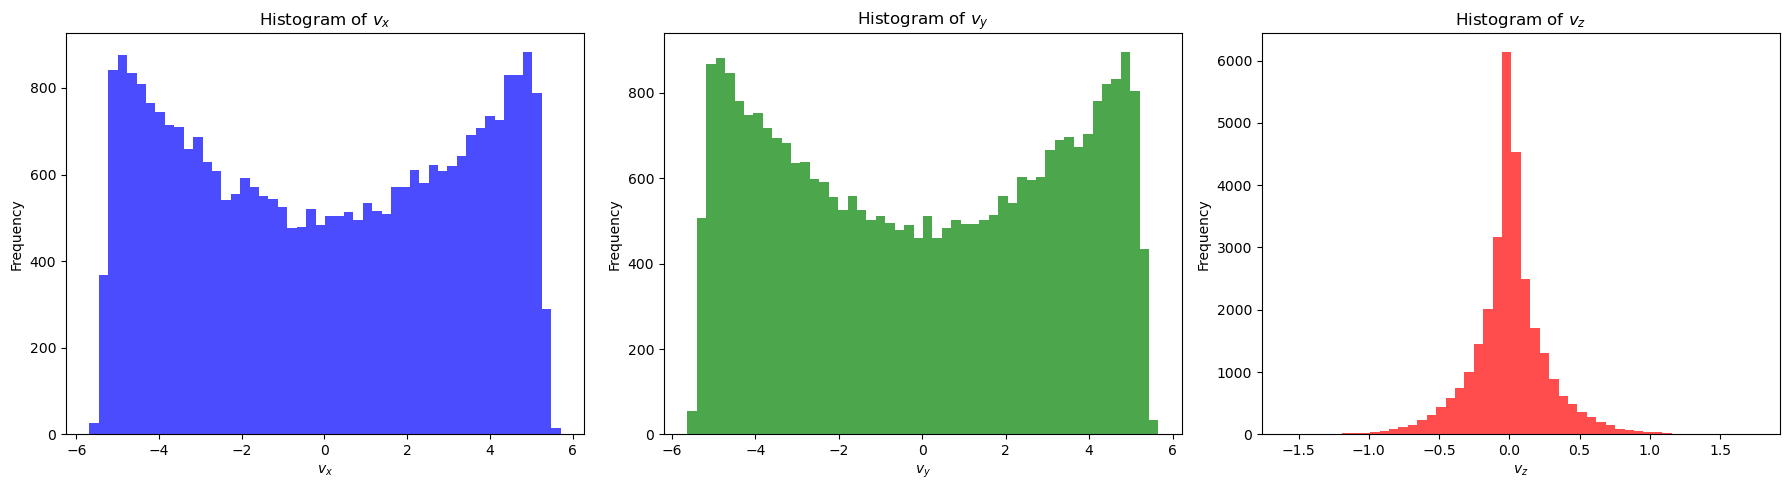

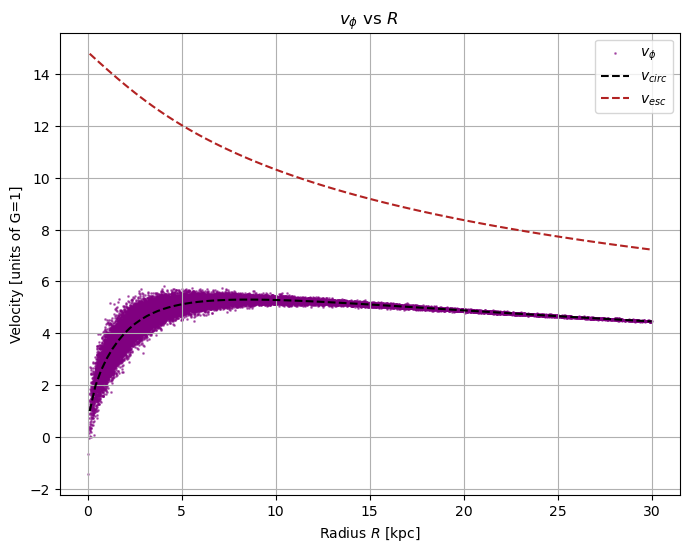

In [78]:
# Histograms of the three velocity components
plt.figure(figsize=(18, 5))

# Histogram of v_x
plt.subplot(131)
plt.hist(v_x, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of $v_x$')
plt.xlabel('$v_x$')
plt.ylabel('Frequency')

# Histogram of v_y
plt.subplot(132)
plt.hist(v_y, bins=50, color='green', alpha=0.7)
plt.title('Histogram of $v_y$')
plt.xlabel('$v_y$')
plt.ylabel('Frequency')

# Histogram of v_z
plt.subplot(133)
plt.hist(v_z, bins=50, color='red', alpha=0.7)
plt.title('Histogram of $v_z$')
plt.xlabel('$v_z$')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

R_grid = np.linspace(0.1, R_max, 100)
# Scatter plot of v_phi as a function of R with circular velocity overplotted
plt.figure(figsize=(8, 6))
plt.scatter(R_particles, v_phi, s=1, color='purple', alpha=0.5, label='$v_\\phi$')
plt.plot(R_grid, v_circ(R_grid), color='black', linestyle='--', label='$v_{circ}$')
plt.plot(R_grid, escape_vel(R_grid, 0), color='firebrick', linestyle='--', label='$v_{esc}$')
plt.xlabel('Radius $R$ [kpc]')
plt.ylabel('Velocity [units of G=1]')
plt.title('$v_\\phi$ vs $R$ ')
plt.legend()
plt.grid(True)
plt.show()

# Let's try to form a bar:
when epiciclic frequency and orbital frequency are the same!
bar is a resonance...

valori di velocità perchè si formi la barra


risonanza di Lindblad interna (ILR). Puoi studiare il profilo di velocità rotazionale Vc(R)Vc​(R) per verificare la presenza di risonanze chiave.

$$
f(R) = \Omega_{tot} (R) - \frac{1}{2} k_{tot} (R)
$$


20085
[4.84131928 3.6602814  6.20637504 5.04324079 5.72900163 3.68054794
 2.46712424 5.05115478 4.97177644 4.91017703 2.24330872 4.75408163
 3.4936865  3.75468891 5.71299705 4.10975428 5.98896257 4.89820216
 2.84247288 5.78610708 2.46924114 4.3283881  4.0516287  6.08015075
 6.34281907 4.58970283 4.32230536 5.56721058 4.36709572 5.19301628
 4.1685564  6.62893221 3.70607551 4.96941304 4.88264199 3.61096409
 4.49290109 4.77591863 6.79809306 3.94900107 1.9010647  3.2611664
 5.63853822 6.94465643 4.89073288 4.34564708 6.01467286 6.79995094
 5.72444599 4.02815274 3.58180933 2.92972154 4.19020744 3.97450048
 3.93893466 6.06091314 5.18565231 3.50727614 5.89978191 5.70879434
 5.29734828 5.71930695 2.42213076 5.55048207 6.85894038 4.00053671
 2.19620957 5.72812419 4.46651607 6.77217058 3.85807523 5.67531268
 4.40829516 4.76947322 2.42872038 5.86384384 5.78741745 5.16609842
 3.79358898 6.77172742 4.5777148  5.52153695 4.59296233]
1.9010647042224507 6.944656430691983 83


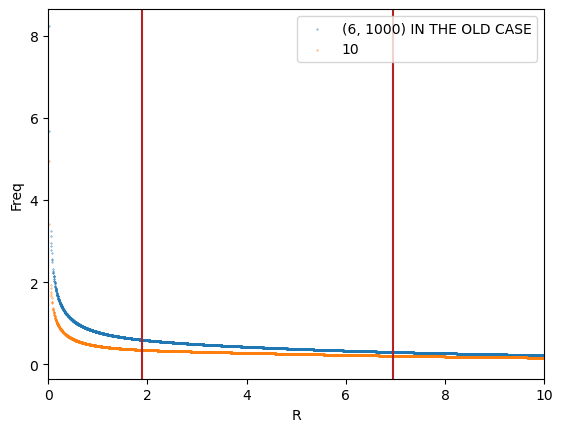

In [79]:
def freq(R):
    return omega(R) - 0.5 * kappa(R)



R_part_interval = R_particles[ (R_particles > 0) & (R_particles < 7)]
print(len(R_part_interval))

a_H = 6

M_H = 1000
plt.scatter(R_particles, freq(R_particles), s = 0.1, label = f'{a_H, M_H} IN THE OLD CASE')

a_H = 10

M_H = 1000
plt.scatter(R_particles, freq(R_particles), s = 0.1, label = f'{a_H}')


np.gradient(freq(R_particles), R_particles)
zero_crossings = np.where(np.isclose(np.gradient(freq(R_part_interval), R_part_interval), 0, atol=1e-3))[0]
print(R_part_interval[zero_crossings])
min_interval = np.min(R_part_interval[zero_crossings])
max_interval = np.max(R_part_interval[zero_crossings])
print(min_interval, max_interval, len(zero_crossings))

plt.axvline(min_interval, color='firebrick')
plt.axvline(max_interval, color='firebrick')


plt.xlabel('R')
plt.ylabel('Freq')
plt.xlim(0, 10)
#plt.ylim(0, 0.2)
plt.legend()



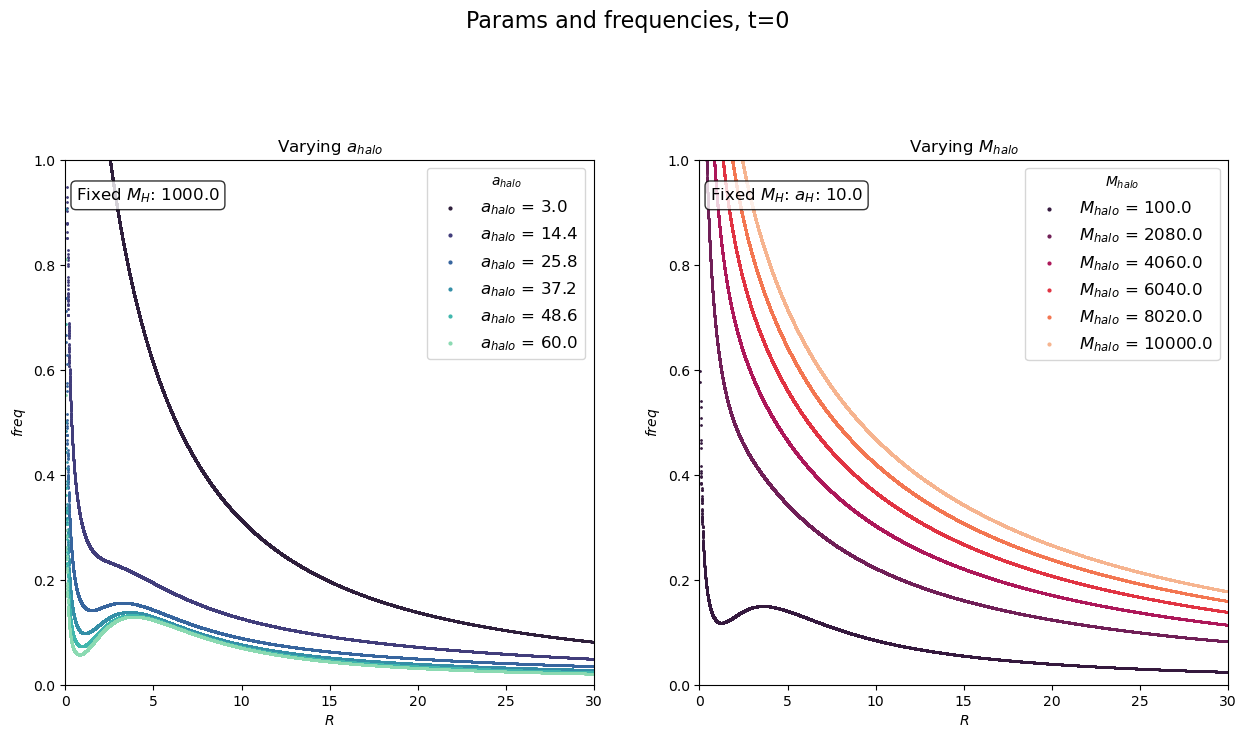

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

if len(zero_crossings) < 500:
    def freq(R):
        return omega(R) - 0.5 * kappa(R)

    a_halo_i = np.linspace(1, 20, 6) * a
    M_halo_i = np.linspace(0.1, 10, 6) * M_H

 
    # Crea palette di colori pastello
    colors_a_halo = sns.color_palette("mako", len(a_halo_i))
    colors_M_halo = sns.color_palette("rocket", len(M_halo_i))

    fig = plt.figure(figsize=(15, 15))
    fig.suptitle('Params and frequencies, t=0', fontsize=16)

    # Plot for varying a_H
    ax1 = fig.add_subplot(221)
    for idx, a_H in enumerate(a_halo_i):
        ax1.scatter(R_particles, freq(R_particles), s=1, color=colors_a_halo[idx], label=f'$a_{{halo}}$ = {a_H:.1f}')

    ax1.set_ylim(0, 1)
    ax1.set_xlim(0, 30)
    ax1.set_xlabel('$R$')
    ax1.set_ylabel('$freq$')
    ax1.legend(loc='upper right', fontsize='large', title='$a_{halo}$', scatterpoints=1, markerscale=2)
    ax1.set_title('Varying $a_{halo}$')

    # Add fixed parameters box
    ax1.text(
        0.02, 0.95, f'Fixed $M_H$: {M_H:.1f}',
        transform=ax1.transAxes, fontsize=12, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )

    a_H = 10

    # Plot for varying M_H
    ax2 = fig.add_subplot(222)
    for idx, M_H in enumerate(M_halo_i):
        ax2.scatter(R_particles, freq(R_particles), s=1, color=colors_M_halo[idx], label=f'$M_{{halo}}$ = {M_H:.1f}')

    ax2.set_ylim(0, 1)
    ax2.set_xlim(0, 30)
    ax2.set_xlabel('$R$')
    ax2.set_ylabel('$freq$')
    ax2.legend(loc='upper right', fontsize='large', title='$M_{halo}$', scatterpoints=1, markerscale=2)
    ax2.set_title('Varying $M_{halo}$')

    # Add fixed parameters box
    ax2.text(
        0.02, 0.95, f'Fixed $M_H$: $a_H$: {a_H:.1f}',
        transform=ax2.transAxes, fontsize=12, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )

    # Reset to original values
    M_H = 1000
    a_H = 10
else:
    print("The zero_crossings vector is not shorter than 500.")


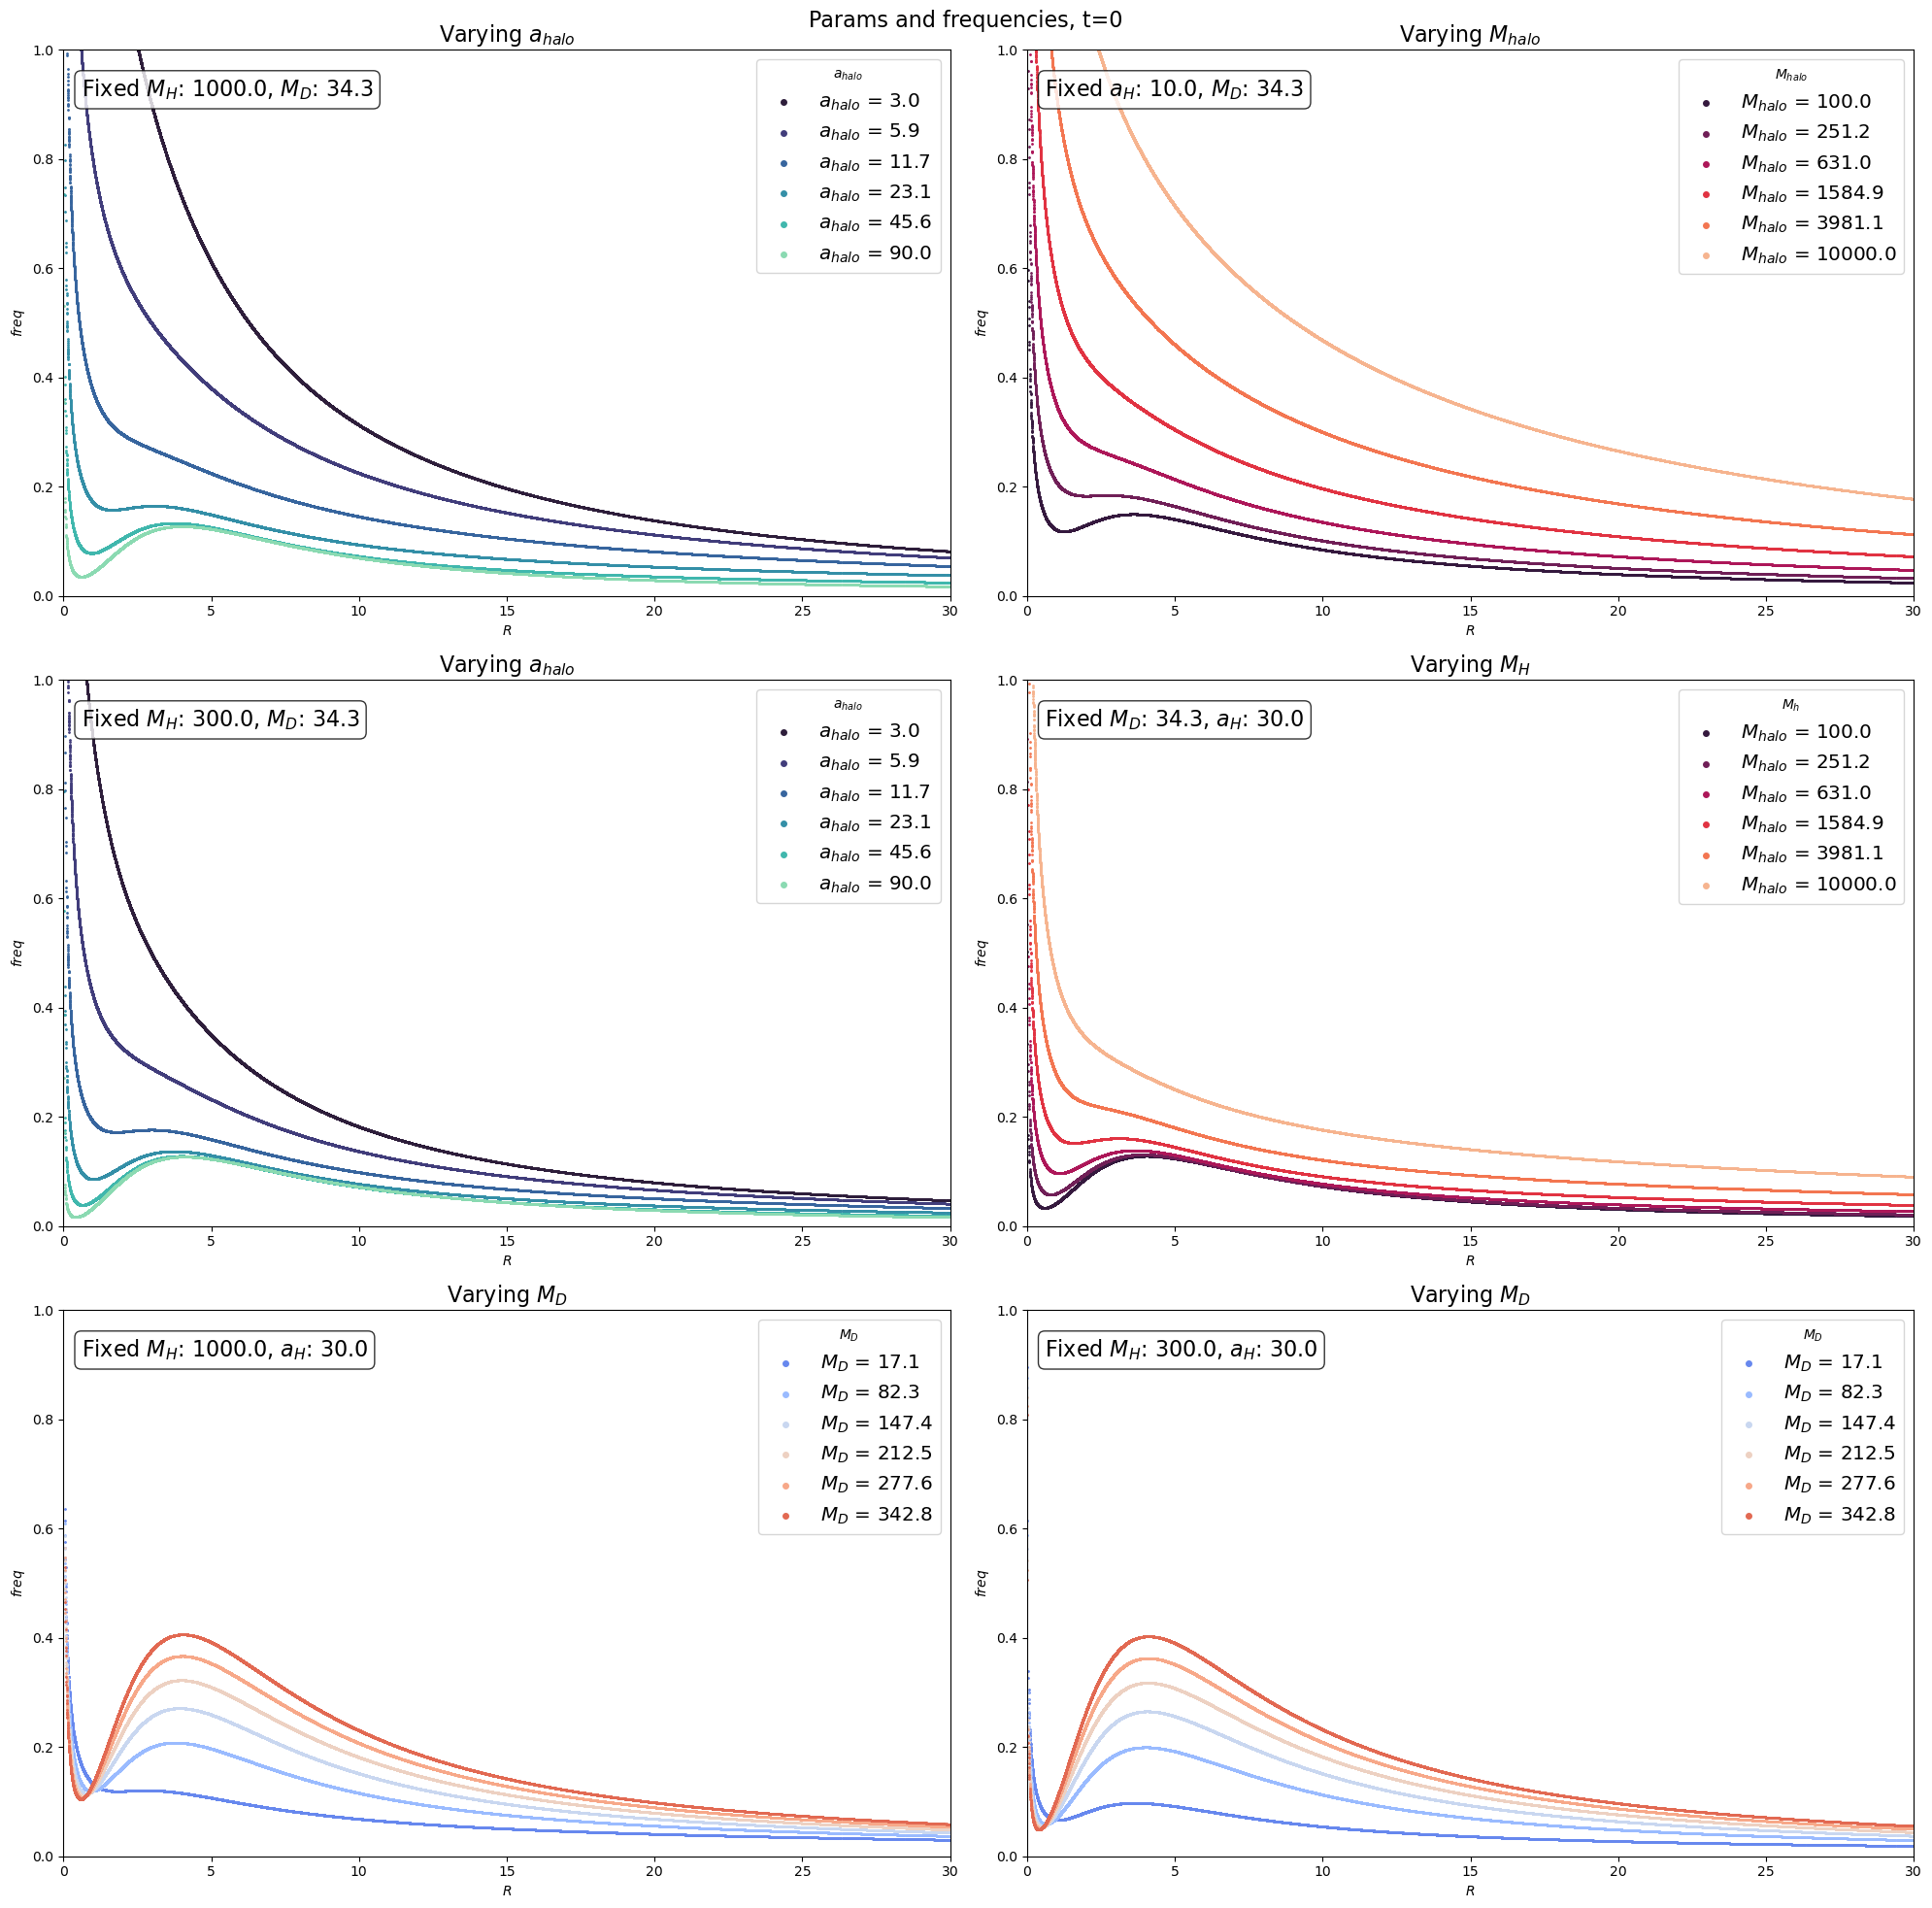

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import emcee
import corner

if len(zero_crossings) < 500:
    
    a_halo_i = np.geomspace(1, 30, 6) * a
    M_halo_i = np.geomspace(0.1, 10, 6) * M_H
    M_D_i = np.linspace(0.5, 10, 6) * M_D  # Define M_D range

    # Valori fissati
    fixed_params = f'Fixed $M_H$: {M_H:.1f}, $a_H$: {a_H:.1f}, $M_D$: {M_D:.1f}'

    # Crea palette di colori pastello
    colors_a_halo = sns.color_palette("mako", len(a_halo_i))
    colors_M_halo = sns.color_palette("rocket", len(M_halo_i))
    colors_M_D = sns.color_palette("coolwarm", len(M_D_i))  # Palette for M_D

    fig = plt.figure(figsize=(20, 20))
    fig.suptitle('Params and frequencies, t=0', fontsize=16)

    # Plot for varying a_H
    ax1 = fig.add_subplot(321)
    for idx, a_H in enumerate(a_halo_i):
        ax1.scatter(R_particles, freq(R_particles), s=1, color=colors_a_halo[idx], label=f'$a_{{halo}}$ = {a_H:.1f}')

    ax1.set_ylim(0, 1)
    ax1.set_xlim(0, 30)
    ax1.set_xlabel('$R$')
    ax1.set_ylabel('$freq$')
    ax1.legend(loc='upper right', fontsize='x-large', title='$a_{halo}$', scatterpoints=1, markerscale=4)
    ax1.set_title('Varying $a_{halo}$', fontsize = 16)

    # Add fixed parameters box
    ax1.text(
        0.02, 0.95,  f'Fixed $M_H$: {M_H:.1f}, $M_D$: {M_D:.1f}',
        transform=ax1.transAxes, fontsize=16, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )


    a_H = 10

    # Plot for varying M_H
    ax2 = fig.add_subplot(322)
    for idx, M_H in enumerate(M_halo_i):
        ax2.scatter(R_particles, freq(R_particles), s=1, color=colors_M_halo[idx], label=f'$M_{{halo}}$ = {M_H:.1f}')

    ax2.set_ylim(0, 1)
    ax2.set_xlim(0, 30)
    ax2.set_xlabel('$R$')
    ax2.set_ylabel('$freq$')
    ax2.legend(loc='upper right', fontsize='x-large', title='$M_{halo}$', scatterpoints=1, markerscale=4)
    ax2.set_title('Varying $M_{halo}$',fontsize = 16 )

    # Add fixed parameters box
    ax2.text(
        0.02, 0.95, f'Fixed $a_H$: {a_H:.1f}, $M_D$: {M_D:.1f}',
        transform=ax2.transAxes, fontsize=16, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )

    M_H = 1000  
    a_H = 30

    # Plot for varying M_H with higher a_H
    ax4 = fig.add_subplot(324)
    for idx, M_H in enumerate(M_halo_i):
        ax4.scatter(R_particles, freq(R_particles), s=1, color=colors_M_halo[idx], label=f'$M_{{halo}}$ = {M_H:.1f}')


    ax4.set_ylim(0, 1)
    ax4.set_xlim(0, 30)
    ax4.set_xlabel('$R$')
    ax4.set_ylabel('$freq$')
    ax4.legend(loc='upper right', fontsize='x-large', title='$M_h$', scatterpoints=1, markerscale=4)
    ax4.set_title( 'Varying $M_{H}$',fontsize = 16)

    # Add fixed parameters box
    ax4.text(
        0.02, 0.95, f'Fixed $M_D$: {M_D:.1f}, $a_H$: {a_H:.1f}',
        transform=ax4.transAxes, fontsize=16, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )

    M_H = 1000
    a_H = 30

    # Plot for varying M_D
    ax5 = fig.add_subplot(325)
    for idx, M_D in enumerate(M_D_i):
        ax5.scatter(R_particles, freq(R_particles), s=1, color=colors_M_D[idx], label=f'$M_{{D}}$ = {M_D:.1f}')

    ax5.set_ylim(0, 1)
    ax5.set_xlim(0, 30)
    ax5.set_xlabel('$R$')
    ax5.set_ylabel('$freq$')
    ax5.legend(loc='upper right', fontsize='x-large', title='$M_D$', scatterpoints=1, markerscale=4)
    ax5.set_title('Varying $M_{D}$',fontsize = 16)

    # Add fixed parameters box
    ax5.text(
        0.02, 0.95, f'Fixed $M_H$: {M_H:.1f}, $a_H$: {a_H:.1f}',
        transform=ax5.transAxes, fontsize=16, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )


    M_D = M_D_1
    M_H = 300

     # Plot for varying a_H
    ax3 = fig.add_subplot(323)
    for idx, a_H in enumerate(a_halo_i):
        ax3.scatter(R_particles, freq(R_particles), s=1, color=colors_a_halo[idx], label=f'$a_{{halo}}$ = {a_H:.1f}')

    ax3.set_ylim(0, 1)
    ax3.set_xlim(0, 30)
    ax3.set_xlabel('$R$')
    ax3.set_ylabel('$freq$')
    ax3.legend(loc='upper right', fontsize='x-large', title='$a_{halo}$', scatterpoints=1, markerscale=4)
    ax3.set_title('Varying $a_{halo}$', fontsize = 16)

    # Add fixed parameters box
    ax3.text(
        0.02, 0.95, f'Fixed $M_H$: {M_H:.1f}, $M_D$: {M_D:.1f}',
        transform=ax3.transAxes, fontsize=16, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )


    a_H = 30
    M_H = 300


    # Plot for varying M_D
    ax6 = fig.add_subplot(326)
    for idx, M_D in enumerate(M_D_i):
        ax6.scatter(R_particles, freq(R_particles), s=1, color=colors_M_D[idx], label=f'$M_{{D}}$ = {M_D:.1f}')
    
    ax6.set_ylim(0, 1)
    ax6.set_xlim(0, 30)
    ax6.set_xlabel('$R$')
    ax6.set_ylabel('$freq$')
    ax6.legend(loc='upper right', fontsize='x-large', title='$M_D$', scatterpoints=1, markerscale=4)
    ax6.set_title('Varying $M_{D}$',fontsize = 16)

    # Add fixed parameters box
    ax6.text(
        0.02, 0.95, f'Fixed $M_H$: {M_H:.1f}, $a_H$: {a_H:.1f}',
        transform=ax6.transAxes, fontsize=16, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )
    
    plt.tight_layout()
    plt.show()

    # Reset to original values
    M_H = 1000
    a_H = 10
    M_D = M_D_1
else:
    print("The zero_crossings vector is not shorter than 500.")


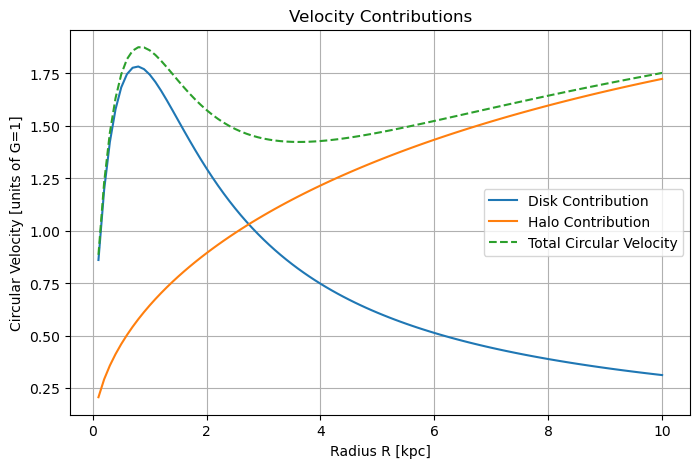

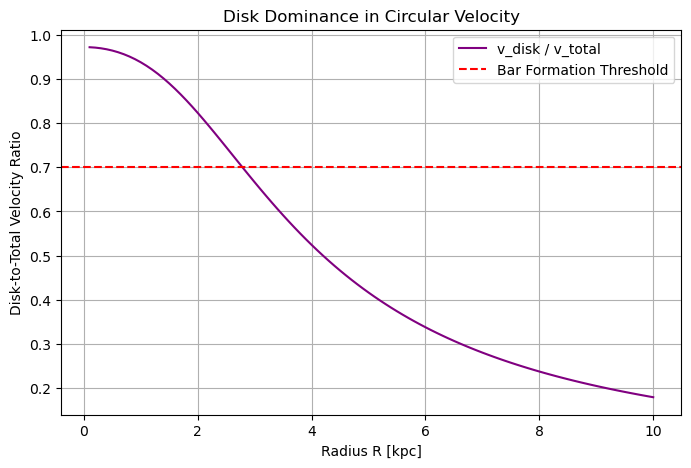

In [82]:

# Functions for circular velocity contributions
def v_circ_disk(R, G=1, M_D=10, a=1, b=0.1):
    """Circular velocity from the disk potential."""
    return np.sqrt(G * M_D * R / ((a + np.sqrt(b**2 + 0**2))**2 + R**2)**(3/2))

def v_circ_halo(R, G=1, M_H=1000, a_h=48):
    """Circular velocity from the halo potential."""
    return np.sqrt(G * M_H * R / (R + a_h)**2)

# Radial range for analysis
R_values = np.linspace(0.1, 10, 100)  # 0.1 to avoid division by zero

# Calculate velocities
v_disk = v_circ_disk(R_values)
v_halo = v_circ_halo(R_values)
v_total = np.sqrt(v_disk**2 + v_halo**2)

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(R_values, v_disk, label="Disk Contribution")
plt.plot(R_values, v_halo, label="Halo Contribution")
plt.plot(R_values, v_total, label="Total Circular Velocity", linestyle="--")
plt.xlabel("Radius R [kpc]")
plt.ylabel("Circular Velocity [units of G=1]")
plt.legend()
plt.title("Velocity Contributions")
plt.grid()
plt.show()

# Disk-to-Halo Ratio
v_ratio = v_disk / v_total
plt.figure(figsize=(8, 5))
plt.plot(R_values, v_ratio, label="v_disk / v_total", color="purple")
plt.axhline(0.7, linestyle="--", color="red", label="Bar Formation Threshold")
plt.xlabel("Radius R [kpc]")
plt.ylabel("Disk-to-Total Velocity Ratio")
plt.legend()
plt.title("Disk Dominance in Circular Velocity")
plt.grid()
plt.show()


### Treecode parameters

In [83]:
print(a, b, M_D, M_H, a_H)

3 0.30000000000000004 34.27515185606664 1000 10


In [84]:
b/a

0.10000000000000002

In [85]:
#volume = np.pi * a**2 * (np.max(z_particles)*2)
volume = (M_D+1.1425)  / np.max(rho_D(np.array(R_particles), np.array(z_particles)))
softening = ((volume/num_particles)**(1/3))

print(f'Softening parameter = {softening:.3f}')

Softening parameter = 0.106


In [86]:
softening 

0.10623197474014907

In [87]:
#timestep = 0.0001 * np.sqrt((softening*10)**3/m_particles) #stiamo facendo radice di xmin/amax in cui amax= GM/x_min^2 x_min=softening

## QUESTO È SBAGLIATOOOOOOOOOO -----> devo prendere l'accelerazione massima.... non quella a distanza softening

#nulla ci vieta di tempo orbitale in funzione del raggio e trovo minimo

#print(f'Timestep of the simulation = {timestep:.5e}')

In [88]:

#senza peturber
def calculate_accelerations(R, z):
    # Distanza radiale effettiva (incluso softening)
    r = np.sqrt(R**2 + z**2 )

    # Accelerazione dovuta all'alone Hernquist
    denominator_halo = (r + a_H)**2
    acc_R_halo = -G * M_H * R / (r * denominator_halo)
    acc_z_halo = -G * M_H * z / (r * denominator_halo)


    # Potenziale del disco
    sqrt_zb2 = np.sqrt(z**2 + b**2)
    denominator_disk = ((a + sqrt_zb2)**2 + R**2)**1.5
    acc_R_disk = -G * M_D * R / denominator_disk
    acc_z_disk = -G * M_D * z * (a + sqrt_zb2) / (sqrt_zb2 * denominator_disk)

    # Accelerazioni totali
    acc_R_total = acc_R_halo + acc_R_disk
    acc_z_total = acc_z_halo + acc_z_disk
    return acc_R_total, acc_z_total

# Calcolo delle accelerazioni
acc_R, acc_z = calculate_accelerations(np.array(R_particles), np.array(z_particles))

# Modulo dell'accelerazione totale per ogni particella
acc_total = np.sqrt(acc_R**2 + acc_z**2)

# Accelerazione massima
acc_max = np.max(acc_total)

print(f"L'accelerazione massima è: {acc_max:.5e}")

L'accelerazione massima è: 1.14554e+01


In [89]:
dt = 0.5 * np.sqrt(softening / acc_max)
print('Timestep:', dt)

Timestep: 0.048149637044990264


In [90]:
# Calculate orbital period (T)
T = 2 * np.pi * R_particles / v_circ(R_particles) # Orbital period estimate

print('orbital periods: ', T, '\n one could put a timestep of 1/100 of the smallest orbital period', np.min(T)/100)

orbital periods:  [ 6.14039797  2.3866598  12.5976401  ...  4.02374265 35.41471015
 12.547858  ] 
 one could put a timestep of 1/100 of the smallest orbital period 0.0017050923674294754


In [91]:
rho_mean = np.mean(rho_D(np.array(R_particles), np.array(z_particles)))
t_dyn = np.sqrt(1/rho_mean)

print(f'Dynamical timescale = {t_dyn}')

Dynamical timescale = 2.469788801175007


In [92]:
def w_onfile(filename, num_points, mass, dimension, x, y, z, v_x, v_y, v_z):
    
    with open(filename, 'w') as file:
        file.write(f'  {num_points} \n  {dimension} \n  {0}  \n')
        for i in range(num_points):
            file.write(f'  {mass}  \n')
        for i in range(num_points):
            file.write(f'  {x[i]}  {y[i]}  {z[i]}  \n')
        for i in range(num_points):
            file.write(f'  {v_x[i]}  {v_y[i]}  {v_z[i]} \n')
            
filename = 'treecode_in_EQUILIBRIUM.txt'

w_onfile(filename, num_particles, M_D/num_particles, 3, x_particles, y_particles, z_particles, v_x, v_y, v_z) 

In [80]:
#treecode prima volta

# ./treecode_ah_10/treecode in=ttreecode_in_EQUILIBRIUM.txt out=treecode_out_EQUILIBRIUM.txt dtime=0.005 eps=0.106 theta=0.3 tstop=100 dtout=1.5 > output_EQUILIBRIUM.txt



# ./treecode/treecode in=treecode_in_prova_1000_bodies.txt out=treecode_out_prova_1000_bodies.txt dtime=0.00000007 eps=0.25 theta=0.1 tstop=0.0005 dtout=0.0000001


In [176]:
num_particles

30000

In [217]:
b

0.03

In [70]:
t_dyn *50



134.68741793379303